<a href="https://colab.research.google.com/github/yosedie/ai-project/blob/main/ai_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ai-project

https://id.wikibooks.org/wiki/Permainan_Tradisional_%22Catur%22_di_Indonesia/Macanan_(Yogyakarta)#Macanan_8_uwong_dan_2_macan

=== Macanan 8 ''uwong'' dan 2 ''macan'' ===

map di GUI

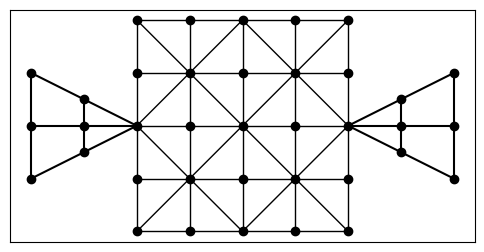

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def draw_board(size):
    # Ukuran grid
    gap = size // 5
    node_radius = 0.08

    # Menyiapkan array untuk posisi nodes
    nodes_pos = []

    # Membuat plot untuk papan
    fig, ax = plt.subplots(figsize=(6, 6))

    # Menggambar grid
    for row in range(5):
        for col in range(5):
            x = col * gap
            y = row * gap
            ax.plot(x, y, 'ko', markersize=6)  # Titik

            # Garis horizontal dan vertikal
            if col < 4:  # Horizontal
                ax.plot([x, x + gap], [y, y], 'k-', lw=1)
            if row < 4:  # Vertikal
                ax.plot([x, x], [y, y + gap], 'k-', lw=1)

            # Garis diagonal bergantian
            if col < 4 and row < 4:
                if (row + col) % 2 == 0:
                    ax.plot([x, x + gap], [y, y + gap], 'k-', lw=1)  # Diagonal \
                else:
                    ax.plot([x + gap, x], [y, y + gap], 'k-', lw=1)  # Diagonal /

            nodes_pos.append((x, y))

    # Segitiga kiri
    left_center_x = 0
    left_center_y = 2 * gap
    triangle_width = 2 * gap
    ax.plot([left_center_x, left_center_x - triangle_width], [left_center_y, left_center_y - gap], 'k-')
    ax.plot([left_center_x, left_center_x - triangle_width], [left_center_y, left_center_y + gap], 'k-')
    ax.plot([left_center_x - triangle_width, left_center_x - triangle_width],
            [left_center_y - gap, left_center_y + gap], 'k-')

    ax.plot([left_center_x - gap, left_center_x - gap],
            [left_center_y - gap/2, left_center_y + gap/2], 'k-')
    ax.plot([left_center_x - triangle_width, left_center_x],
            [left_center_y, left_center_y], 'k-')

    left_nodes = [
        (left_center_x - triangle_width, left_center_y - gap),
        (left_center_x - triangle_width, left_center_y),
        (left_center_x - triangle_width, left_center_y + gap),
        (left_center_x - gap, left_center_y - gap/2),
        (left_center_x - gap, left_center_y),
        (left_center_x - gap, left_center_y + gap/2),
    ]

    for (x, y) in left_nodes:
        ax.plot(x, y, 'ko', markersize=6)

    nodes_pos.extend(left_nodes)

    # Segitiga kanan
    right_center_x = 4 * gap
    right_center_y = 2 * gap
    ax.plot([right_center_x, right_center_x + triangle_width],
            [right_center_y, right_center_y - gap], 'k-')
    ax.plot([right_center_x, right_center_x + triangle_width],
            [right_center_y, right_center_y + gap], 'k-')
    ax.plot([right_center_x + triangle_width, right_center_x + triangle_width],
            [right_center_y - gap, right_center_y + gap], 'k-')

    ax.plot([right_center_x + gap, right_center_x + gap],
            [right_center_y - gap/2, right_center_y + gap/2], 'k-')
    ax.plot([right_center_x, right_center_x + triangle_width],
            [right_center_y, right_center_y], 'k-')

    right_nodes = [
        (right_center_x + triangle_width, right_center_y - gap),
        (right_center_x + triangle_width, right_center_y),
        (right_center_x + triangle_width, right_center_y + gap),
        (right_center_x + gap, right_center_y - gap/2),
        (right_center_x + gap, right_center_y),
        (right_center_x + gap, right_center_y + gap/2),
    ]

    for (x, y) in right_nodes:
        ax.plot(x, y, 'ko', markersize=6)

    nodes_pos.extend(right_nodes)

    # Pengaturan sumbu dan tampilan
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

    # Menampilkan papan
    plt.show()

# Panggil fungsi untuk menggambar papan
draw_board(400)


map di CUI

In [38]:
def draw_board(size):
    gap = size // 5  # Ukuran jarak antar titik
    grid = [[' ' for _ in range(5)] for _ in range(5)]  # Inisialisasi grid 5x5

    # Mengisi titik-titik pada grid 5x5
    for row in range(5):
        for col in range(5):
            grid[row][col] = '.'

    # Menambahkan titik pada segitiga kiri
    left_triangle = [
        (2, 0),
        (1, 1),
        (1, 3),
        (0, 1),
        (0, 2),
        (0, 3)
    ]
    for (r, c) in left_triangle:
        grid[r][c] = '.'

    # Menambahkan titik pada segitiga kanan
    right_triangle = [
        (2, 4),
        (3, 1),
        (3, 3),
        (4, 1),
        (4, 2),
        (4, 3)
    ]
    for (r, c) in right_triangle:
        grid[r][c] = '.'

    # Menampilkan grid
    for row in grid:
        print(' '.join(row))

# Menampilkan papan
draw_board(400)


. . . . .
. . . . .
. . . . .
. . . . .
. . . . .


2 player

In [7]:
import numpy as np

# Representasi papan sebagai matriks
board = np.zeros((5, 5), dtype=int)

# Koordinat valid (bentuk papan permainan)
valid_positions = [
    (0, 0), (0, 2), (0, 4),
    (1, 1), (1, 3),
    (2, 0), (2, 1), (2, 2), (2, 3), (2, 4),
    (3, 1), (3, 3),
    (4, 0), (4, 2), (4, 4)
]

# Menampilkan papan
def print_board():
    for i in range(5):
        row = ""
        for j in range(5):
            if (i, j) not in valid_positions:
                row += "   "  # Posisi tidak valid
            elif board[i, j] == 0:
                row += " . "  # Kosong
            elif board[i, j] == 1:
                row += " M "  # Macan
            elif board[i, j] == 2:
                row += " U "  # Uwong
        print(row)
    print("\n")

# Cek apakah langkah valid
def is_valid_move(x, y):
    return (x, y) in valid_positions and board[x, y] == 0

# Fungsi untuk peletakan pion Uwong oleh player
def place_uwong_player(board, message="Letakkan pion Uwong!"):
    print(message)
    while True:
        x, y = map(int, input("Masukkan posisi Uwong (x y): ").split())
        if (x, y) in valid_positions and board[x, y] == 0:
            board[x, y] = 2
            break
        else:
            print(f"Posisi ({x}, {y}) sudah terisi atau tidak valid!")

# Fungsi untuk peletakan pion Macan oleh AI
def place_macan_ai(board, message="AI menempatkan pion Macan."):
    # Memastikan hanya ada dua pion Macan
    if np.sum(board == 1) >= 2:
        print("Macan sudah memiliki dua pion. Tidak bisa menambah lebih dari dua.")
        return False  # Tidak meletakkan pion lagi jika sudah ada 2 pion Macan

    available_positions = [(i, j) for i, j in valid_positions if board[i, j] == 0]
    if available_positions:
        chosen_pos = available_positions[0]  # Pilih posisi pertama yang kosong
        board[chosen_pos[0], chosen_pos[1]] = 1  # Pion Macan
        print(f"AI menempatkan pion Macan di {chosen_pos}")
        return True
    return False


# Cek apakah Macan bisa bergerak
def can_macans_move(board):
    macan_positions = [(i, j) for i, j in valid_positions if board[i, j] == 1]
    for mx, my in macan_positions:
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-2, 0), (2, 0), (0, -2), (0, 2)]:
            nx, ny = mx + dx, my + dy
            if is_valid_move(nx, ny):  # Gerakan biasa
                return True
            if can_jump(mx, my, nx, ny):  # Lompat di atas Uwong
                return True
    return False

# Cek jika Macan bisa lompat ke posisi tertentu
def can_jump(mx, my, nx, ny):
    middle_x, middle_y = (mx + nx) // 2, (my + ny) // 2
    if (middle_x, middle_y) in valid_positions and board[middle_x, middle_y] == 2:  # Ada Uwong di tengah
        return True
    return False

# Menilai kondisi akhir permainan
def game_over(board):
    if np.sum(board == 2) == 0:  # Jika tidak ada Uwong
        print("Macan menang! Semua Uwong telah diterkam.")
        return True

    if not can_macans_move(board):  # Jika Macan tidak bisa bergerak
        print("Macan kalah! Macan tidak bisa bergerak.")
        return True

    return False

# Fungsi untuk mencari semua langkah yang mungkin untuk pemain
def get_all_possible_moves(board, player):
    moves = []
    if player == 2:  # Uwong
        uwong_positions = [(i, j) for i, j in valid_positions if board[i, j] == 2]
        for ux, uy in uwong_positions:
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = ux + dx, uy + dy
                if is_valid_move(nx, ny):
                    moves.append(((ux, uy), (nx, ny)))
    elif player == 1:  # Macan
        macan_positions = [(i, j) for i, j in valid_positions if board[i, j] == 1]
        for mx, my in macan_positions:
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-2, 0), (2, 0), (0, -2), (0, 2)]:
                nx, ny = mx + dx, my + dy
                if is_valid_move(nx, ny) or can_jump(mx, my, nx, ny):  # Jika bisa bergerak atau lompat
                    moves.append(((mx, my), (nx, ny)))
    return moves

def apply_move(board, move, player):
    new_board = board.copy()
    ((x1, y1), (x2, y2)) = move  # Ambil langkah dari pasangan posisi awal dan posisi tujuan
    if is_valid_move(x2, y2):  # Pastikan langkah yang diterapkan valid
        new_board[x2, y2] = player
        new_board[x1, y1] = 0  # Kosongkan posisi awal
    return new_board

# Minimax algorithm
def minimax(board, depth, is_maximizing_player):
    if depth == 0 or game_over(board):
        return evaluate(board)

    if is_maximizing_player:  # Macan (AI)
        max_eval = float('-inf')
        for move in get_all_possible_moves(board, player=1):  # Macan
            new_board = apply_move(board, move, player=1)
            eval = minimax(new_board, depth - 1, False)
            max_eval = max(max_eval, eval)
        return max_eval
    else:  # Uwong (Player)
        min_eval = float('inf')
        for move in get_all_possible_moves(board, player=2):  # Uwong
            new_board = apply_move(board, move, player=2)
            eval = minimax(new_board, depth - 1, True)
            min_eval = min(min_eval, eval)
        return min_eval

# Evaluasi papan
def evaluate(board):
    # Penilaian sederhana: lebih banyak Uwong, lebih buruk bagi Macan
    uwong_count = np.sum(board == 2)
    macan_count = np.sum(board == 1)
    return uwong_count - macan_count  # Uwong menang lebih baik

# Fungsi untuk memilih langkah terbaik untuk Macan menggunakan AI (Minimax)
def minimax_ai(board):
    best_score = float('-inf')
    best_move = None
    # Ambil semua langkah yang memungkinkan untuk Macan
    for move in get_all_possible_moves(board, player=1):  # Macan (1)
        new_board = apply_move(board, move, player=1)
        score = minimax(new_board, 3, False)  # Kedalaman 3
        if score > best_score:
            best_score = score
            best_move = move
    return best_move

# Fungsi permainan utama yang disesuaikan
def main():
    uwong_count = 8
    placed_uwong = 0
    macan_count = 2
    current_player = 2  # Player mulai dengan Uwong (2)

    # Peletakan pion Uwong dan Macan secara bergantian: Uwong, Macan, Uwong, Macan
    print_board()

    place_uwong_player(board, message="Letakkan pion Uwong pertama!")
    placed_uwong += 1
    print_board()

    # Macan menaruh pion pertama
    place_macan_ai(board, message="AI menempatkan pion Macan pertama.")
    print_board()

    # Uwong menaruh pion kedua
    place_uwong_player(board, message="Letakkan pion Uwong kedua!")
    placed_uwong += 1
    print_board()

    # Macan menaruh pion kedua
    place_macan_ai(board, message="AI menempatkan pion Macan kedua.")
    print_board()

    # Permainan dimulai setelah peletakan selesai
    while True:
        print_board()

        if current_player == 2:  # Giliran Uwong (Player)
            print("Giliran Uwong (Player)")
            # Tambahkan 6 pion lagi ke papan
            while placed_uwong < uwong_count:
                place_uwong_player(board)
                placed_uwong += 1
                print_board()
            current_player = 1  # Ganti giliran ke Macan (AI)

        # Periksa apakah permainan sudah berakhir setelah langkah Uwong
        if game_over(board):
            print_board()
            break  # Jika permainan berakhir, hentikan perulangan

        if current_player == 1:  # Giliran Macan (AI)
            print("Giliran Macan (AI)")

            # Pilih langkah terbaik untuk Macan menggunakan AI (Minimax)
            move = minimax_ai(board)
            if move:
                (x1, y1), (x2, y2) = move
                board[x2, y2] = 1
                board[x1, y1] = 0
                current_player = 2  # Ganti giliran ke Uwong (Player)

        # Periksa apakah permainan sudah berakhir setelah langkah Macan
        if game_over(board):
            print_board()
            break  # Jika permainan berakhir, hentikan perulangan

if __name__ == "__main__":
    main()

 .     .     . 
    .     .    
 .  .  .  .  . 
    .     .    
 .     .     . 


AI menempatkan pion Macan di (0, 0)
 M     .     . 
    .     .    
 .  .  .  .  . 
    .     .    
 .     .     . 


AI menempatkan pion Uwong pertama!


KeyboardInterrupt: Interrupted by user

AI macan

In [6]:
import numpy as np

# Representasi papan sebagai matriks
board = np.zeros((5, 5), dtype=int)

# Koordinat valid (bentuk papan permainan)
valid_positions = [
    (0, 0), (0, 2), (0, 4),
    (1, 1), (1, 3),
    (2, 0), (2, 1), (2, 2), (2, 3), (2, 4),
    (3, 1), (3, 3),
    (4, 0), (4, 2), (4, 4)
]

# Menampilkan papan
def print_board():
    for i in range(5):
        row = ""
        for j in range(5):
            if (i, j) not in valid_positions:
                row += "   "  # Posisi tidak valid
            elif board[i, j] == 0:
                row += " . "  # Kosong
            elif board[i, j] == 1:
                row += " M "  # Macan
            elif board[i, j] == 2:
                row += " U "  # Uwong
        print(row)
    print("\n")

# Cek apakah langkah valid
def is_valid_move(x, y):
    return (x, y) in valid_positions and board[x, y] == 0

# Fungsi untuk peletakan pion Uwong oleh player
def place_uwong_player(board, message="Letakkan pion Uwong!"):
    print(message)
    while True:
        x, y = map(int, input("Masukkan posisi Uwong (x y): ").split())
        if (x, y) in valid_positions and board[x, y] == 0:
            board[x, y] = 2
            break
        else:
            print(f"Posisi ({x}, {y}) sudah terisi atau tidak valid!")

# Fungsi untuk peletakan pion Macan oleh AI
def place_macan_ai(board, message="AI menempatkan pion Macan."):
    # Memastikan hanya ada dua pion Macan
    if np.sum(board == 1) >= 2:
        print("Macan sudah memiliki dua pion. Tidak bisa menambah lebih dari dua.")
        return False  # Tidak meletakkan pion lagi jika sudah ada 2 pion Macan

    available_positions = [(i, j) for i, j in valid_positions if board[i, j] == 0]
    if available_positions:
        chosen_pos = available_positions[0]  # Pilih posisi pertama yang kosong
        board[chosen_pos[0], chosen_pos[1]] = 1  # Pion Macan
        print(f"AI menempatkan pion Macan di {chosen_pos}")
        return True
    return False


# Cek apakah Macan bisa bergerak
def can_macans_move(board):
    macan_positions = [(i, j) for i, j in valid_positions if board[i, j] == 1]
    for mx, my in macan_positions:
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-2, 0), (2, 0), (0, -2), (0, 2)]:
            nx, ny = mx + dx, my + dy
            if is_valid_move(nx, ny):  # Gerakan biasa
                return True
            if can_jump(mx, my, nx, ny):  # Lompat di atas Uwong
                return True
    return False

# Cek jika Macan bisa lompat ke posisi tertentu
def can_jump(mx, my, nx, ny):
    middle_x, middle_y = (mx + nx) // 2, (my + ny) // 2
    if (middle_x, middle_y) in valid_positions and board[middle_x, middle_y] == 2:  # Ada Uwong di tengah
        return True
    return False

# Menilai kondisi akhir permainan
def game_over(board):
    if np.sum(board == 2) == 0:  # Jika tidak ada Uwong
        print("Macan menang! Semua Uwong telah diterkam.")
        return True

    if not can_macans_move(board):  # Jika Macan tidak bisa bergerak
        print("Macan kalah! Macan tidak bisa bergerak.")
        return True

    return False

# Fungsi untuk mencari semua langkah yang mungkin untuk pemain
def get_all_possible_moves(board, player):
    moves = []
    if player == 2:  # Uwong
        uwong_positions = [(i, j) for i, j in valid_positions if board[i, j] == 2]
        for ux, uy in uwong_positions:
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = ux + dx, uy + dy
                if is_valid_move(nx, ny):
                    moves.append(((ux, uy), (nx, ny)))
    elif player == 1:  # Macan
        macan_positions = [(i, j) for i, j in valid_positions if board[i, j] == 1]
        for mx, my in macan_positions:
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-2, 0), (2, 0), (0, -2), (0, 2)]:
                nx, ny = mx + dx, my + dy
                if is_valid_move(nx, ny) or can_jump(mx, my, nx, ny):  # Jika bisa bergerak atau lompat
                    moves.append(((mx, my), (nx, ny)))
    return moves

def apply_move(board, move, player):
    new_board = board.copy()
    ((x1, y1), (x2, y2)) = move  # Ambil langkah dari pasangan posisi awal dan posisi tujuan
    if is_valid_move(x2, y2):  # Pastikan langkah yang diterapkan valid
        new_board[x2, y2] = player
        new_board[x1, y1] = 0  # Kosongkan posisi awal
    return new_board

# Minimax algorithm
def minimax(board, depth, is_maximizing_player):
    if depth == 0 or game_over(board):
        return evaluate(board)

    if is_maximizing_player:  # Macan (AI)
        max_eval = float('-inf')
        for move in get_all_possible_moves(board, player=1):  # Macan
            new_board = apply_move(board, move, player=1)
            eval = minimax(new_board, depth - 1, False)
            max_eval = max(max_eval, eval)
        return max_eval
    else:  # Uwong (Player)
        min_eval = float('inf')
        for move in get_all_possible_moves(board, player=2):  # Uwong
            new_board = apply_move(board, move, player=2)
            eval = minimax(new_board, depth - 1, True)
            min_eval = min(min_eval, eval)
        return min_eval

# Evaluasi papan
def evaluate(board):
    # Penilaian sederhana: lebih banyak Uwong, lebih buruk bagi Macan
    uwong_count = np.sum(board == 2)
    macan_count = np.sum(board == 1)
    return uwong_count - macan_count  # Uwong menang lebih baik

# Fungsi untuk memilih langkah terbaik untuk Macan menggunakan AI (Minimax)
def minimax_ai(board):
    best_score = float('-inf')
    best_move = None
    # Ambil semua langkah yang memungkinkan untuk Macan
    for move in get_all_possible_moves(board, player=1):  # Macan (1)
        new_board = apply_move(board, move, player=1)
        score = minimax(new_board, 3, False)  # Kedalaman 3
        if score > best_score:
            best_score = score
            best_move = move
    return best_move

# Fungsi permainan utama yang disesuaikan
def main():
    uwong_count = 8
    placed_uwong = 0
    macan_count = 2
    current_player = 2  # Player mulai dengan Uwong (2)

    # Peletakan pion Uwong dan Macan secara bergantian: Uwong, Macan, Uwong, Macan
    print_board()

    place_uwong_player(board, message="Letakkan pion Uwong pertama!")
    placed_uwong += 1
    print_board()

    # Macan menaruh pion pertama
    place_macan_ai(board, message="AI menempatkan pion Macan pertama.")
    print_board()

    # Uwong menaruh pion kedua
    place_uwong_player(board, message="Letakkan pion Uwong kedua!")
    placed_uwong += 1
    print_board()

    # Macan menaruh pion kedua
    place_macan_ai(board, message="AI menempatkan pion Macan kedua.")
    print_board()

    # Permainan dimulai setelah peletakan selesai
    while True:
        print_board()

        if current_player == 2:  # Giliran Uwong (Player)
            print("Giliran Uwong (Player)")
            # Tambahkan 6 pion lagi ke papan
            while placed_uwong < uwong_count:
                place_uwong_player(board)
                placed_uwong += 1
                print_board()
            current_player = 1  # Ganti giliran ke Macan (AI)

        # Periksa apakah permainan sudah berakhir setelah langkah Uwong
        if game_over(board):
            print_board()
            break  # Jika permainan berakhir, hentikan perulangan

        if current_player == 1:  # Giliran Macan (AI)
            print("Giliran Macan (AI)")

            # Pilih langkah terbaik untuk Macan menggunakan AI (Minimax)
            move = minimax_ai(board)
            if move:
                (x1, y1), (x2, y2) = move
                board[x2, y2] = 1
                board[x1, y1] = 0
                current_player = 2  # Ganti giliran ke Uwong (Player)

        # Periksa apakah permainan sudah berakhir setelah langkah Macan
        if game_over(board):
            print_board()
            break  # Jika permainan berakhir, hentikan perulangan

if __name__ == "__main__":
    main()

 .     .     . 
    .     .    
 .  .  .  .  . 
    .     .    
 .     .     . 


Letakkan pion Uwong pertama!
Masukkan posisi Uwong (x y): 0 0
 U     .     . 
    .     .    
 .  .  .  .  . 
    .     .    
 .     .     . 


AI menempatkan pion Macan di (0, 2)
 U     M     . 
    .     .    
 .  .  .  .  . 
    .     .    
 .     .     . 


Letakkan pion Uwong kedua!
Masukkan posisi Uwong (x y): 1 1
 U     M     . 
    U     .    
 .  .  .  .  . 
    .     .    
 .     .     . 


AI menempatkan pion Macan di (0, 4)
 U     M     M 
    U     .    
 .  .  .  .  . 
    .     .    
 .     .     . 


 U     M     M 
    U     .    
 .  .  .  .  . 
    .     .    
 .     .     . 


Giliran Uwong (Player)
Letakkan pion Uwong!
Masukkan posisi Uwong (x y): 2 2
 U     M     M 
    U     .    
 .  .  U  .  . 
    .     .    
 .     .     . 


Letakkan pion Uwong!
Masukkan posisi Uwong (x y): 2 3
 U     M     M 
    U     .    
 .  .  U  U  . 
    .     .    
 .     .     . 


Letakkan pion Uwong

AI uwong

In [17]:
import numpy as np

# Representasi papan sebagai matriks
board = np.zeros((5, 5), dtype=int)

# Koordinat valid (bentuk papan permainan)
valid_positions = [
    (0, 0), (0, 2), (0, 4),
    (1, 1), (1, 3),
    (2, 0), (2, 1), (2, 2), (2, 3), (2, 4),
    (3, 1), (3, 3),
    (4, 0), (4, 2), (4, 4)
]

# Menampilkan papan
def print_board():
    for i in range(5):
        row = ""
        for j in range(5):
            if (i, j) not in valid_positions:
                row += "   "  # Posisi tidak valid
            elif board[i, j] == 0:
                row += " . "  # Kosong
            elif board[i, j] == 1:
                row += " M "  # Macan
            elif board[i, j] == 2:
                row += " U "  # Uwong
        print(row)
    print("\n")

# Cek apakah langkah valid
def is_valid_move(x, y):
    return (x, y) in valid_positions and board[x, y] == 0

# Fungsi untuk peletakan pion Macan oleh player
def place_macan_player(board, message="Letakkan pion Macan!"):
    print(message)
    while True:
        x, y = map(int, input("Masukkan posisi Macan (x y): ").split())
        if (x, y) in valid_positions and board[x, y] == 0:
            board[x, y] = 1
            break
        else:
            print(f"Posisi ({x}, {y}) sudah terisi atau tidak valid!")

# Fungsi untuk peletakan pion Uwong oleh AI
def place_uwong_ai(board, message="AI menempatkan pion Uwong."):
    # Memastikan hanya ada 8 pion Uwong
    if np.sum(board == 2) >= 8:
        print("Uwong sudah memiliki 8 pion. Tidak bisa menambah lebih dari delapan.")
        return False  # Tidak meletakkan pion lagi jika sudah ada 8 pion Uwong

    available_positions = [(i, j) for i, j in valid_positions if board[i, j] == 0]
    if available_positions:
        chosen_pos = available_positions[0]  # Pilih posisi pertama yang kosong
        board[chosen_pos[0], chosen_pos[1]] = 2  # Pion Uwong
        print(f"AI menempatkan pion Uwong di {chosen_pos}")
        return True
    return False


# Cek apakah Macan bisa bergerak
def can_macans_move(board):
    macan_positions = [(i, j) for i, j in valid_positions if board[i, j] == 1]
    for mx, my in macan_positions:
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-2, 0), (2, 0), (0, -2), (0, 2)]:
            nx, ny = mx + dx, my + dy
            if is_valid_move(nx, ny):  # Gerakan biasa
                return True
            if can_jump(mx, my, nx, ny):  # Lompat di atas Uwong
                return True
    return False

# Cek jika Macan bisa lompat ke posisi tertentu
def can_jump(mx, my, nx, ny):
    middle_x, middle_y = (mx + nx) // 2, (my + ny) // 2
    if (middle_x, middle_y) in valid_positions and board[middle_x, middle_y] == 2:  # Ada Uwong di tengah
        return True
    return False

# Menilai kondisi akhir permainan
def game_over(board):
    if np.sum(board == 2) == 0:  # Jika tidak ada Uwong
        print("Macan menang! Semua Uwong telah diterkam.")
        return True

    if not can_macans_move(board):  # Jika Macan tidak bisa bergerak
        print("Macan kalah! Macan tidak bisa bergerak.")
        return True

    return False

# Fungsi untuk mencari semua langkah yang mungkin untuk pemain
def get_all_possible_moves(board, player):
    moves = []
    if player == 2:  # Uwong
        uwong_positions = [(i, j) for i, j in valid_positions if board[i, j] == 2]
        for ux, uy in uwong_positions:
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = ux + dx, uy + dy
                if is_valid_move(nx, ny):
                    moves.append(((ux, uy), (nx, ny)))
    elif player == 1:  # Macan
        macan_positions = [(i, j) for i, j in valid_positions if board[i, j] == 1]
        for mx, my in macan_positions:
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-2, 0), (2, 0), (0, -2), (0, 2)]:
                nx, ny = mx + dx, my + dy
                if is_valid_move(nx, ny) or can_jump(mx, my, nx, ny):  # Jika bisa bergerak atau lompat
                    moves.append(((mx, my), (nx, ny)))
    return moves

def apply_move(board, move, player):
    new_board = board.copy()
    ((x1, y1), (x2, y2)) = move  # Ambil langkah dari pasangan posisi awal dan posisi tujuan
    if is_valid_move(x2, y2):  # Pastikan langkah yang diterapkan valid
        new_board[x2, y2] = player
        new_board[x1, y1] = 0  # Kosongkan posisi awal
    return new_board

# Minimax algorithm
def minimax(board, depth, is_maximizing_player):
    if depth == 0 or game_over(board):
        return evaluate(board)

    if is_maximizing_player:  # Uwong (AI)
        max_eval = float('-inf')
        for move in get_all_possible_moves(board, player=2):  # Uwong
            new_board = apply_move(board, move, player=2)
            eval = minimax(new_board, depth - 1, False)
            max_eval = max(max_eval, eval)
        return max_eval
    else:  # Macan (Player)
        min_eval = float('inf')
        for move in get_all_possible_moves(board, player=1):  # Macan
            new_board = apply_move(board, move, player=1)
            eval = minimax(new_board, depth - 1, True)
            min_eval = min(min_eval, eval)
        return min_eval

# Evaluasi papan
def evaluate(board):
    # Penilaian sederhana: lebih banyak Uwong, lebih buruk bagi Macan
    uwong_count = np.sum(board == 2)
    macan_count = np.sum(board == 1)
    return uwong_count - macan_count  # Uwong menang lebih baik

# Fungsi untuk memilih langkah terbaik untuk Uwong menggunakan AI (Minimax)
def minimax_ai(board):
    best_score = float('-inf')
    best_move = None
    # Ambil semua langkah yang memungkinkan untuk Uwong
    for move in get_all_possible_moves(board, player=2):  # Uwong (2)
        new_board = apply_move(board, move, player=2)
        score = minimax(new_board, 3, False)  # Kedalaman 3
        if score > best_score:
            best_score = score
            best_move = move
    return best_move

# Fungsi permainan utama yang disesuaikan
def main():
    uwong_count = 8
    placed_uwong = 0
    macan_count = 2
    current_player = 1  # Player mulai dengan Macan (1)

    # Peletakan pion Macan dan Uwong secara bergantian: Macan, Uwong, Macan, Uwong
    print_board()

    place_macan_player(board, message="Letakkan pion Macan pertama!")
    print_board()

    # AI menaruh pion pertama
    place_uwong_ai(board, message="AI menempatkan pion Uwong pertama.")
    print_board()

    # Macan menaruh pion kedua
    place_macan_player(board, message="Letakkan pion Macan kedua!")
    print_board()

    # AI menaruh pion kedua
    place_uwong_ai(board, message="AI menempatkan pion Uwong kedua.")
    print_board()

    # Permainan dimulai setelah peletakan selesai
    while True:
        print_board()

        if current_player == 1:  # Giliran Macan (Player)
            print("Giliran Macan (Player)")
            current_player = 2  # Ganti giliran ke Uwong (AI)

        # Periksa apakah permainan sudah berakhir setelah langkah Macan
        if game_over(board):
            print_board()
            break  # Jika permainan berakhir, hentikan perulangan

        if current_player == 2:  # Giliran Uwong (AI)
            print("Giliran Uwong (AI)")

            # Pilih langkah terbaik untuk Uwong menggunakan AI (Minimax)
            move = minimax_ai(board)
            if move:
                (x1, y1), (x2, y2) = move
                board[x2, y2] = 2
                board[x1, y1] = 0
                current_player = 1  # Ganti giliran ke Macan (Player)

        # Periksa apakah permainan sudah berakhir setelah langkah Uwong
        if game_over(board):
            print_board()
            break  # Jika permainan berakhir, hentikan perulangan

if __name__ == "__main__":
    main()


Streaming output truncated to the last 5000 lines.
 .  .  M  .  . 
    .     .    
 .     .     . 


Giliran Uwong (AI)
 M     U     U 
    .     .    
 .  .  M  .  . 
    .     .    
 .     .     . 


Giliran Uwong (AI)
 M     U     U 
    .     .    
 .  .  M  .  . 
    .     .    
 .     .     . 


Giliran Uwong (AI)
 M     U     U 
    .     .    
 .  .  M  .  . 
    .     .    
 .     .     . 


Giliran Uwong (AI)
 M     U     U 
    .     .    
 .  .  M  .  . 
    .     .    
 .     .     . 


Giliran Uwong (AI)
 M     U     U 
    .     .    
 .  .  M  .  . 
    .     .    
 .     .     . 


Giliran Uwong (AI)
 M     U     U 
    .     .    
 .  .  M  .  . 
    .     .    
 .     .     . 


Giliran Uwong (AI)
 M     U     U 
    .     .    
 .  .  M  .  . 
    .     .    
 .     .     . 


Giliran Uwong (AI)
 M     U     U 
    .     .    
 .  .  M  .  . 
    .     .    
 .     .     . 


Giliran Uwong (AI)
 M     U     U 
    .     .    
 .  .  M  .  . 
    .     .    
 .     .

KeyboardInterrupt: 

2 AI

In [ ]:
import numpy as np

# Representasi papan sebagai matriks
board = np.zeros((5, 5), dtype=int)

# Koordinat valid (bentuk papan permainan)
valid_positions = [
    (0, 0), (0, 2), (0, 4),
    (1, 1), (1, 3),
    (2, 0), (2, 1), (2, 2), (2, 3), (2, 4),
    (3, 1), (3, 3),
    (4, 0), (4, 2), (4, 4)
]

import time

# Fungsi untuk menampilkan papan permainan
def print_board():
    for i in range(5):
        row = ""
        for j in range(5):
            if (i, j) not in valid_positions:
                row += "   "  # Posisi tidak valid
            elif board[i, j] == 0:
                row += " . "  # Kosong
            elif board[i, j] == 1:
                row += " M "  # Macan
            elif board[i, j] == 2:
                row += " U "  # Uwong
        print(row)
    print("\n")

# Cek apakah langkah valid
def is_valid_move(x, y):
    return (x, y) in valid_positions and board[x, y] == 0

# Fungsi untuk peletakan pion Macan atau Uwong oleh AI
def place_piece_ai(board, player):
    available_positions = [(i, j) for i, j in valid_positions if board[i, j] == 0]
    if available_positions:
        chosen_pos = available_positions[0]  # Pilih posisi pertama yang kosong
        board[chosen_pos[0], chosen_pos[1]] = player
        return True
    return False

# Cek apakah Macan bisa bergerak
def can_macans_move(board):
    macan_positions = [(i, j) for i, j in valid_positions if board[i, j] == 1]
    for mx, my in macan_positions:
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-2, 0), (2, 0), (0, -2), (0, 2)]:
            nx, ny = mx + dx, my + dy
            if is_valid_move(nx, ny):  # Gerakan biasa
                return True
            if can_jump(mx, my, nx, ny):  # Lompat di atas Uwong
                return True
    return False

# Cek jika Macan bisa lompat ke posisi tertentu
def can_jump(mx, my, nx, ny):
    middle_x, middle_y = (mx + nx) // 2, (my + ny) // 2
    if (middle_x, middle_y) in valid_positions and board[middle_x, middle_y] == 2:  # Ada Uwong di tengah
        return True
    return False

# Menilai kondisi akhir permainan
def game_over(board):
    if np.sum(board == 2) == 0:  # Jika tidak ada Uwong
        print("Macan menang! Semua Uwong telah diterkam.")
        return True

    if not can_macans_move(board):  # Jika Macan tidak bisa bergerak
        print("Macan kalah! Macan tidak bisa bergerak.")
        return True

    return False

# Fungsi untuk mencari semua langkah yang mungkin untuk pemain
def get_all_possible_moves(board, player):
    moves = []
    if player == 2:  # Uwong
        uwong_positions = [(i, j) for i, j in valid_positions if board[i, j] == 2]
        for ux, uy in uwong_positions:
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = ux + dx, uy + dy
                if is_valid_move(nx, ny):
                    moves.append(((ux, uy), (nx, ny)))
    elif player == 1:  # Macan
        macan_positions = [(i, j) for i, j in valid_positions if board[i, j] == 1]
        for mx, my in macan_positions:
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-2, 0), (2, 0), (0, -2), (0, 2)]:
                nx, ny = mx + dx, my + dy
                if is_valid_move(nx, ny) or can_jump(mx, my, nx, ny):  # Jika bisa bergerak atau lompat
                    moves.append(((mx, my), (nx, ny)))
    return moves

def apply_move(board, move, player):
    new_board = board.copy()
    ((x1, y1), (x2, y2)) = move  # Ambil langkah dari pasangan posisi awal dan posisi tujuan
    if is_valid_move(x2, y2):  # Pastikan langkah yang diterapkan valid
        new_board[x2, y2] = player
        new_board[x1, y1] = 0  # Kosongkan posisi awal
    return new_board

# Minimax algorithm
def minimax(board, depth, is_maximizing_player):
    if depth == 0 or game_over(board):  # Memeriksa game over lebih awal
        return evaluate(board)  # Kembalikan nilai evaluasi

    if is_maximizing_player:  # Macan (AI)
        max_eval = float('-inf')
        for move in get_all_possible_moves(board, player=1):  # Macan
            new_board = apply_move(board, move, player=1)
            eval = minimax(new_board, depth - 1, False)
            max_eval = max(max_eval, eval)
        return max_eval
    else:  # Uwong (AI)
        min_eval = float('inf')
        for move in get_all_possible_moves(board, player=2):  # Uwong
            new_board = apply_move(board, move, player=2)
            eval = minimax(new_board, depth - 1, True)
            min_eval = min(min_eval, eval)
        return min_eval

# Evaluasi papan
def evaluate(board):
    # Penilaian sederhana: lebih banyak Uwong, lebih buruk bagi Macan
    uwong_count = np.sum(board == 2)
    macan_count = np.sum(board == 1)
    return uwong_count - macan_count  # Uwong menang lebih baik

# Fungsi untuk memilih langkah terbaik untuk Macan menggunakan AI (Minimax)
def minimax_ai(board):
    best_score = float('-inf')
    best_move = None
    # Ambil semua langkah yang memungkinkan untuk Macan
    for move in get_all_possible_moves(board, player=1):  # Macan (1)
        new_board = apply_move(board, move, player=1)
        score = minimax(new_board, 3, False)  # Kedalaman 3
        if score > best_score:
            best_score = score
            best_move = move
    return best_move

# Fungsi untuk memilih langkah terbaik untuk Uwong menggunakan AI (Minimax)
def minimax_uwong(board):
    best_score = float('inf')
    best_move = None
    # Ambil semua langkah yang memungkinkan untuk Uwong
    for move in get_all_possible_moves(board, player=2):  # Uwong (2)
        new_board = apply_move(board, move, player=2)
        score = minimax(new_board, 3, True)  # Kedalaman 3
        if score < best_score:
            best_score = score
            best_move = move
    return best_move

# Fungsi permainan utama yang disesuaikan
def main():
    placed_uwong = 0
    uwong_count = 8
    macan_count = 2
    current_player = 2  # Player mulai dengan Uwong (2)

    # Peletakan pion Uwong dan Macan secara bergantian: Uwong, Macan, Uwong, Macan
    print_board()

    place_piece_ai(board, player=2)  # AI Uwong
    placed_uwong += 1
    print_board()

    place_piece_ai(board, player=1)  # AI Macan
    print_board()

    place_piece_ai(board, player=2)  # AI Uwong
    placed_uwong += 1
    print_board()

    place_piece_ai(board, player=1)  # AI Macan
    print_board()

    # Permainan dimulai setelah peletakan selesai
    while True:
        print_board()

        if current_player == 2:  # Giliran Uwong (AI)
            print("Giliran Uwong (AI)")
            # Tambahkan sisa pion Uwong
            while placed_uwong < uwong_count:
                place_piece_ai(board, player=2)
                placed_uwong += 1
                print_board()
            current_player = 1  # Ganti giliran ke Macan (AI)

        # Periksa apakah permainan sudah berakhir setelah langkah Uwong
        if game_over(board):
            print_board()  # Cetak papan setelah akhir permainan
            break  # Keluar dari perulangan jika permainan selesai

        if current_player == 1:  # Giliran Macan (AI)
            print("Giliran Macan (AI)")

            # Pilih langkah terbaik untuk Macan menggunakan AI (Minimax)
            move = minimax_ai(board)
            if move:
                (x1, y1), (x2, y2) = move
                board[x2, y2] = 1
                board[x1, y1] = 0
                print_board()
                current_player = 2  # Ganti giliran ke Uwong (AI)

        # Periksa apakah permainan sudah berakhir setelah langkah Macan
        if game_over(board):
            print_board()  # Cetak papan setelah akhir permainan
            break  # Keluar dari perulangan jika permainan selesai

if __name__ == "__main__":
    main()

Streaming output truncated to the last 5000 lines.
 U     M     U 
    M     U    
 U  .  U  U  U 
    .     .    
 .     .     . 


 U     M     U 
    M     U    
 U  .  U  U  U 
    .     .    
 .     .     . 


Giliran Uwong (AI)
Giliran Macan (AI)
Macan kalah! Macan tidak bisa bergerak.
Macan kalah! Macan tidak bisa bergerak.
 U     M     U 
    .     U    
 U  M  U  U  U 
    .     .    
 .     .     . 


 U     M     U 
    .     U    
 U  M  U  U  U 
    .     .    
 .     .     . 


Giliran Uwong (AI)
Giliran Macan (AI)
 U     M     U 
    M     U    
 U  .  U  U  U 
    .     .    
 .     .     . 


 U     M     U 
    M     U    
 U  .  U  U  U 
    .     .    
 .     .     . 


Giliran Uwong (AI)
Giliran Macan (AI)
Macan kalah! Macan tidak bisa bergerak.
Macan kalah! Macan tidak bisa bergerak.
 U     M     U 
    .     U    
 U  M  U  U  U 
    .     .    
 .     .     . 


 U     M     U 
    .     U    
 U  M  U  U  U 
    .     .    
 .     .     . 


Giliran Uwong (AI)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




    M     U    
 U  .  U  U  U 
    .     .    
 .     .     . 


 U     M     U 
    M     U    
 U  .  U  U  U 
    .     .    
 .     .     . 


Giliran Uwong (AI)
Giliran Macan (AI)
Macan kalah! Macan tidak bisa bergerak.
Macan kalah! Macan tidak bisa bergerak.
 U     M     U 
    .     U    
 U  M  U  U  U 
    .     .    
 .     .     . 


 U     M     U 
    .     U    
 U  M  U  U  U 
    .     .    
 .     .     . 


Giliran Uwong (AI)
Giliran Macan (AI)
 U     M     U 
    M     U    
 U  .  U  U  U 
    .     .    
 .     .     . 


 U     M     U 
    M     U    
 U  .  U  U  U 
    .     .    
 .     .     . 


Giliran Uwong (AI)
Giliran Macan (AI)
Macan kalah! Macan tidak bisa bergerak.
Macan kalah! Macan tidak bisa bergerak.
 U     M     U 
    .     U    
 U  M  U  U  U 
    .     .    
 .     .     . 


 U     M     U 
    .     U    
 U  M  U  U  U 
    .     .    
 .     .     . 


Giliran Uwong (AI)
Giliran Macan (AI)
 U     M     U 
    M     U    
 U  .  U  U  U 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-74fba3725191>", line 217, in <cell line: 0>
    main()
  File "<ipython-input-19-74fba3725191>", line 203, in main
    move = minimax_ai(board)
           ^^^^^^^^^^^^^^^^^
  File "<ipython-input-19-74fba3725191>", line 138, in minimax_ai
    score = minimax(new_board, 3, False)  # Kedalaman 3
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-19-74fba3725191>", line 120, in minimax
    eval = minimax(new_board, depth - 1, True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-19-74fba3725191>", line 113, in minimax
    eval = minimax(new_board, depth - 1, False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-19-74fba3725191>", line 118, in minimax
    for move in get_all_possible_moves(board, player=2):  # Uwon